# Fraud Detection with Perceptron
This notebook demonstrates how to build a **cost-sensitive Perceptron model** for fraud detection using imbalanced transaction data.

We will:
1. Import necessary libraries
2. Define Perceptron training/prediction functions
3. Load and preprocess transaction data
4. Handle class imbalance with SMOTE
5. Train and evaluate the model
6. Explore precision-recall trade-offs
7. Build an inference helper function.

In [1]:

import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve


## Perceptron Functions
We define a **custom cost-sensitive Perceptron**:
- The `perceptron_train` function updates weights differently for fraud cases (higher penalty).
- Training accuracy is tracked across epochs.
- The `perceptron_predict` function applies the learned weights to classify new samples.

In [2]:

def perceptron_train(x_matrix, y, T, fraud_weight=10):
    theta = np.zeros(x_matrix.shape[1])
    theta_zero = 0
    accuracy_history = []

    for _ in range(T):
        for i in range(x_matrix.shape[0]):
            if y[i] * (np.dot(theta, x_matrix[i]) + theta_zero) <= 0:
                update = y[i] * (fraud_weight if y[i] == 1 else 1)
                theta = theta + update * x_matrix[i]
                theta_zero = theta_zero + update
        y_pred_train = np.where(np.dot(x_matrix, theta) + theta_zero >= 0, 1, -1)
        accuracy_history.append(np.mean(y_pred_train == y))

    return theta, theta_zero, accuracy_history


def perceptron_predict(x_matrix, theta, theta_zero):
    return np.where(np.dot(x_matrix, theta) + theta_zero >= 0, 1, -1)


## Step 1: Load and Explore Data
We load transaction data from CSV, then perform **feature engineering** to extract additional signals such as balance changes and ratios.

In [3]:

df = pd.read_csv("data/transactions.csv")

df['balance_change'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['dest_balance_change'] = df['newbalanceDest'] - df['oldbalanceDest']
df['amount_to_oldbalance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)
df['amount_to_newbalance_ratio'] = df['amount'] / (df['newbalanceOrig'] + 1)


## Step 2: Prepare Features and Target
- Features = all transaction attributes (numeric + categorical)
- Target = `isFraud` (converted to +1 for fraud, -1 for legit).

In [4]:

X_df = df.drop("isFraud", axis=1)
y = np.where(df["isFraud"].values == 1, 1, -1)


## Step 3: Preprocessing
We apply:
- **StandardScaler** for numeric features
- **OneHotEncoder** for categorical features

In [5]:

numeric_features = ["amount", "oldbalanceOrg", "newbalanceOrig",
                    "oldbalanceDest", "newbalanceDest",
                    "balance_change", "dest_balance_change",
                    "amount_to_oldbalance_ratio", "amount_to_newbalance_ratio"]

categorical_features = ["type"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

X = preprocessor.fit_transform(X_df)


## Step 4: Train-Test Split
We split the dataset into training (70%) and testing (30%), stratified on fraud labels to maintain distribution.

In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=(y == 1)
)


## Step 5: Handle Class Imbalance with SMOTE
Fraudulent transactions are rare, so we apply **SMOTE** (Synthetic Minority Oversampling Technique) to balance the training data.

In [7]:

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train + 1))
print("After SMOTE:", np.bincount(y_train_res + 1))


Before SMOTE: [139802      0    197]
After SMOTE: [139802      0 139802]


## Step 6: Train Perceptron
We train for `T=40` epochs and record training accuracy. The learning process is visualized with a line plot.

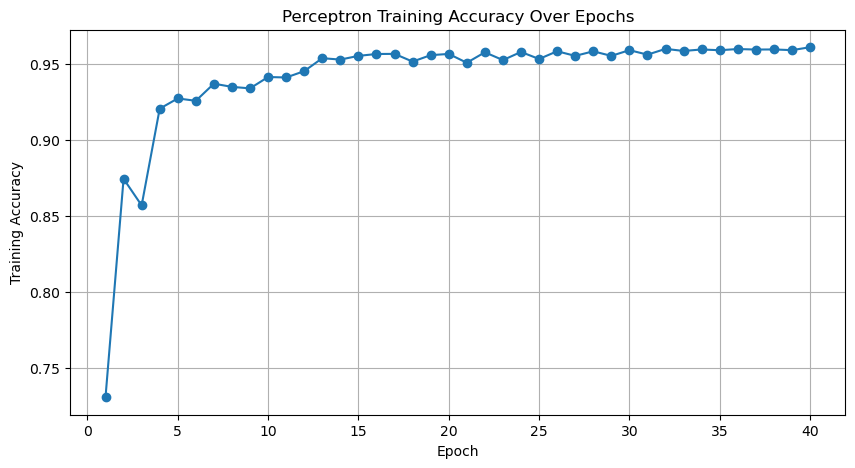

In [8]:

T = 40
theta, theta_zero, acc_history = perceptron_train(X_train_res, y_train_res, T)

plt.figure(figsize=(10, 5))
plt.plot(range(1, T + 1), acc_history, marker='o')
plt.title("Perceptron Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.grid(True)
plt.show()


## Step 7: Evaluate Model with Precision-Recall Trade-offs
- We compute decision scores for the test set.
- We generate a precision-recall curve.
- We select the best threshold that maintains high recall (≥ 0.98).
- Finally, we evaluate with a classification report.

In [9]:

scores = np.dot(X_test, theta) + theta_zero

precision, recall, thresholds = precision_recall_curve(y_test, scores)

target_recall = 0.98
best_thresh = 0
best_acc = 0
for p, r, t in zip(precision, recall, thresholds):
    if r >= target_recall:
        y_pred_temp = np.where(scores >= t, 1, -1)
        acc = np.mean(y_pred_temp == y_test)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t

print(f"Best threshold keeping recall={target_recall}: {best_thresh:.4f}, Accuracy: {best_acc:.4f}")

y_pred = np.where(scores >= best_thresh, 1, -1)

print(classification_report(y_test, y_pred, target_names=["Legit (-1)", "Fraud (+1)"]))


Best threshold keeping recall=0.98: 52.5398, Accuracy: 0.9440
              precision    recall  f1-score   support

  Legit (-1)       1.00      0.94      0.97     59915
  Fraud (+1)       0.02      0.99      0.05        85

    accuracy                           0.94     60000
   macro avg       0.51      0.97      0.51     60000
weighted avg       1.00      0.94      0.97     60000



## Step 8: Inference Helper
We wrap the trained pipeline into a helper function to classify new transactions conveniently.

In [10]:

def flag_transaction(tx_dict, preprocessor, theta, theta_zero):
    tx_df = pd.DataFrame([tx_dict])
    X_tx = preprocessor.transform(tx_df).toarray()
    return "FRAUD" if perceptron_predict(X_tx, theta, theta_zero)[0] == 1 else "LEGIT"
